## FINDING THE BEST LOCATION FOR A TUITION CENTRE IN MELBOURNE, AUSTRALIA

### INSTALL AND IMPORT PACKAGES

In [39]:
# Install required packages
!pip install geopy
!pip install folium

In [48]:
# Import required packages
import pandas as pd
import numpy as np
import types
from botocore.client import Config
import ibm_boto3
import io
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
#from sklearn.cluster import KMeans
import folium
import requests
from project_lib import Project
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors

### POSTCODE DATA WRANGLING

In [41]:
# The code was removed by Watson Studio for sharing.

,postcode,suburb,state,dc,type,lat,lon
0,200,AUSTRALIAN NATIONAL UNIVERSITY,ACT,AUSTRALIAN NATIONAL UNI LPO,Post Office Boxes,-35.277272,149.117136
1,221,BARTON,ACT,NaN,LVR,-35.201372,149.095065
2,800,DARWIN,NT,DARWIN DELIVERY CENTRE,Delivery Area,-12.801028,130.955789
3,801,DARWIN,NT,DARWIN DELIVERY CENTRE,Post Office Boxes,-12.801028,130.955789
4,804,PARAP,NT,PARAP,Post Office Boxes,-12.432181,130.843310


In [54]:
#Drop irrelevant columns
df_suburbdata = df_data_1
df_suburbdata = df_suburbdata.drop(['state', 'dc','type'], axis = 1)
df_suburbdata

#Keep only the rows corresponding to Metropolitan Melbourne
df_melbsuburbs = df_suburbdata.loc[((df_suburbdata['postcode'] >= 3000) & (df_suburbdata['postcode'] <= 3207))|((df_suburbdata['postcode'] >= 8000) & (df_suburbdata['postcode'] <= 8873))]
df_melbsuburbs = df_melbsuburbs.reset_index(drop=True)

#Preview the database to ensure it has been transformed as necessary
df_melbsuburbs.head()

,postcode,suburb,lat,lon
0,3000,MELBOURNE,-37.814563,144.970267
1,3001,MELBOURNE,-38.365017,144.765920
2,3002,EAST MELBOURNE,-37.816640,144.987811
3,3003,WEST MELBOURNE,-37.806255,144.941123
4,3004,MELBOURNE,-37.837324,144.976335


In [55]:
#Check to see if any nulls exist in the dataset.
df_melbsuburbs.isnull().sum()

postcode    0
suburb      0
lat         0
lon         0
dtype: int64

In [56]:
#Check for duplicate postcodes
df_melbsuburbs[df_melbsuburbs['postcode'].duplicated(keep=False)].head()

,postcode,suburb,lat,lon
9,3011,FOOTSCRAY,-37.799770,144.899587
10,3011,SEDDON,-37.808769,144.895486
11,3011,SEDDON WEST,-37.795059,144.866197
12,3012,BROOKLYN,-37.814624,144.847108
13,3012,KINGSVILLE,-37.812635,144.881803


In [57]:
#Group each suburb by unique postcode, creating a concatenated list of suburbs belonging to each postcode
df_aggsuburbs = df_melbsuburbs.groupby('postcode')['suburb'].apply(', '.join).to_frame()
df_aggsuburbs = df_aggsuburbs.reset_index()

#Average the latitude and longitude locations for each postcode
df_aveloc = df_melbsuburbs.groupby('postcode').mean()
df_aveloc = df_aveloc.reset_index()
df_melbpostcodes = pd.merge(df_aggsuburbs,df_aveloc)

#Preview the new table
df_melbpostcodes.head()

,postcode,suburb,lat,lon
0,3000,MELBOURNE,-37.814563,144.970267
1,3001,MELBOURNE,-38.365017,144.765920
2,3002,EAST MELBOURNE,-37.816640,144.987811
3,3003,WEST MELBOURNE,-37.806255,144.941123
4,3004,MELBOURNE,-37.837324,144.976335


### SCHOOL ENROLMENT DATA WRANGLING

In [68]:
# The code was removed by Watson Studio for sharing.

,Education_Sector,Entity_Type,School_No,School_Name,School_Type,School_Status,"Prep Males Total""""","Prep Females Total""""","Prep Total""""","Year 1 Males Total""""","Year 1 Females Total""""","Year 1 Total""""","Year 2 Males total""""","Year 2 Females Total""""","Year 2 Total""""","Year 3 Males Total""""","Year 3 Females Total""""","Year 3 Total""""","Year 4 Males Total""""","Year 4 Females Total""""","Year 4 Total""""","Year 5 Males Total""""","Year 5 Females Total""""","Year 5 Total""""","Year 6 Males Total""""","Year 6 Females Total""""","Year 6 Total""""","Primary Ungraded Males Total""""","Primary Ungraded Females Total""""","Primary Ungraded Total""""","Primary Total""""","Year 7 Males Total""""","Year 7 Females Total""""","Year 7 Total""""","Year 8 Males Total""""","Year 8 Females Total""""","Year 8 Total""""","Year 9 Males Total""""","Year 9 Females Total""""","Year 9 Total""""","Year 10 Males Total""""","Year 10 Females Total""""","Year 10 Total""""","Year 11 Males Total""""","Year 11 Females Total""""","Year 11 Total""""","Year 12 Males""""","Year 12 Females""""","Year 12 Total""""","Secondary Ungraded Males Total""""","Secondary Ungraded Females Total""""","Secondary Ungraded Total""""","Secondary Total""""","Grand Total""""",Year,CENSUS_TYPE
0,Catholic,2,20,Parade College,Secondary,O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,333.0,0.0,333.0,337.0,0.0,337.0,351.0,0.0,351.0,319.0,0.0,319.0,332.0,0.0,332.0,281.0,0.0,281.0,0.0,0.0,0.0,1953.0,1953.0,2020,F
1,Catholic,2,25,Simonds Catholic College,Secondary,O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,64.0,85.0,0.0,85.0,69.0,0.0,69.0,73.0,0.0,73.0,68.0,0.0,68.0,62.0,0.0,62.0,0.0,0.0,0.0,421.0,421.0,2020,F
2,Catholic,2,26,Christian Brothers' College St Kilda,Secondary,O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,54.0,74.0,0.0,74.0,94.0,0.0,94.0,87.0,0.0,87.0,97.0,0.0,97.0,71.0,0.0,71.0,0.0,0.0,0.0,477.0,477.0,2020,F
3,Catholic,2,28,St Patrick's College Ballarat,Secondary,O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,229.0,0.0,229.0,233.0,0.0,233.0,224.0,0.0,224.0,236.0,0.0,236.0,228.0,0.0,228.0,190.0,0.0,190.0,0.0,0.0,0.0,1340.0,1340.0,2020,F
4,Catholic,2,29,St Patrick's School,Primary,O,30.0,12.0,42.0,14.0,18.0,32.0,15.0,16.0,31.0,18.0,15.0,33.0,13.0,21.0,34.0,16.0,22.0,38.0,18.0,27.0,45.0,0.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,2020,F


In [69]:
#Keep only the necessary columns and rename them appropriately
df_enrol = df_enrol[['School_Name','Grand Total""']]
df_enrol = df_enrol.rename(columns={"School_Name": "school", 'Grand Total""': "enrolments"})
df_enrol.head()

,school,enrolments
0,Parade College,1953.0
1,Simonds Catholic College,421.0
2,Christian Brothers' College St Kilda,477.0
3,St Patrick's College Ballarat,1340.0
4,St Patrick's School,255.0


In [70]:
#Check for any null values
df_enrol.isnull().sum()

school        0
enrolments    0
dtype: int64

In [71]:
# The code was removed by Watson Studio for sharing.

,Education_Sector,Entity_Type,School_No,School_Name,School_Type,School_Status,Address_Line_1,Address_Line_2,Address_Town,Address_State,Address_Postcode,Postal_Address_Line_1,Postal_Address_Line_2,Postal_Town,Postal_State,Postal_Postcode,Full_Phone_No,LGA_ID,LGA_Name,X,Y
0,Government,1,1,Alberton Primary School,Primary,O,21 Thomson Street,NaN,Alberton,VIC,3971,21 Thomson Street,NaN,ALBERTON,VIC,3971,03 5183 2412,681,Wellington (S),146.666601,-38.617713
1,Government,1,3,Allansford and District Primary School,Primary,O,Frank Street,NaN,Allansford,VIC,3277,Frank Street,NaN,ALLANSFORD,VIC,3277,03 5565 1382,673,Warrnambool (C),142.590393,-38.386281
2,Government,1,4,Avoca Primary School,Primary,O,118 Barnett Street,NaN,Avoca,VIC,3467,P O Box 12,NaN,AVOCA,VIC,3467,03 5465 3176,599,Pyrenees (S),143.475649,-37.084502
3,Government,1,8,Avenel Primary School,Primary,O,40 Anderson Street,NaN,Avenel,VIC,3664,40 Anderson Street,NaN,AVENEL,VIC,3664,03 5796 2264,643,Strathbogie (S),145.234722,-36.901368
4,Government,1,12,Warrandyte Primary School,Primary,O,5-11 Forbes Street,NaN,Warrandyte,VIC,3113,5-11 Forbes Street,NaN,WARRANDYTE,VIC,3113,03 9844 3537,421,Manningham (C),145.213980,-37.742675


In [72]:
#Keep only school name and postcode data
df_schoolpostcodes = df_schoollocations[['School_Name', 'Postal_Postcode']]
df_schoolpostcodes = df_schoolpostcodes.rename(columns={"School_Name":"school","Postal_Postcode":"postcode"})
df_schoolpostcodes.reset_index(drop=True, inplace=True)
df_schoolpostcodes.head()

,school,postcode
0,Alberton Primary School,3971
1,Allansford and District Primary School,3277
2,Avoca Primary School,3467
3,Avenel Primary School,3664
4,Warrandyte Primary School,3113


In [73]:
#Keep only postcode data in Metropolitan Melbourne
df_schoolpostcodes = df_schoolpostcodes.loc[((df_schoolpostcodes['postcode'] >= 3000) & (df_schoolpostcodes['postcode'] <= 3207))|((df_schoolpostcodes['postcode'] >= 8000) & (df_schoolpostcodes['postcode'] <= 8873))]
df_schoolpostcodes.head()

,school,postcode
4,Warrandyte Primary School,3113
11,Cheltenham Primary School,3192
13,Newport Lakes Primary School,3015
23,Doncaster Primary School,3108
25,Eltham Primary School,3095


In [74]:
#Merge the postcodes and enrolment dataframes along the "school" column
df_schools = pd.merge(df_enrol, df_schoolpostcodes)
df_schools.head()

,school,enrolments,postcode
0,Parade College,1953.0,3083
1,Simonds Catholic College,421.0,3003
2,Christian Brothers' College St Kilda,477.0,3182
3,St Patrick's School,255.0,3140
4,St Patrick's School,255.0,3194


In [76]:
#Group the multiple schools in unique postcodes into total enrolments per postcode
df_enroltotals = df_schools.groupby(['postcode']).sum()
df_enroltotals = df_enroltotals.reset_index()
df_enroltotals.head()

,postcode,enrolments
0,3000,275.7
1,3003,421.0
2,3004,6053.0
3,3006,861.5
4,3011,2937.4


In [77]:
#Perform outer join and fill any NaN values as 0
df_melbenrol = pd.merge(df_melbpostcodes,df_enroltotals,how='outer')
df_melbenrol['enrolments'].fillna(0, inplace=True)
df_melbenrol.enrolments = df_melbenrol.enrolments.astype(int)
df_melbenrol.head()

,postcode,suburb,lat,lon,enrolments
0,3000,MELBOURNE,-37.814563,144.970267,275
1,3001,MELBOURNE,-38.365017,144.765920,0
2,3002,EAST MELBOURNE,-37.816640,144.987811,0
3,3003,WEST MELBOURNE,-37.806255,144.941123,421
4,3004,MELBOURNE,-37.837324,144.976335,6053


In [78]:
#Check for any null values in the new dataframe
df_melbenrol.isnull().sum()

postcode      0
suburb        1
lat           1
lon           1
enrolments    0
dtype: int64

In [79]:
#Check what the row is
df_melbenrol[df_melbenrol.isna().any(axis=1)]

,postcode,suburb,lat,lon,enrolments
230,8008,NaN,NaN,NaN,58


In [80]:
#Dump the row because it's only 58 enrolments (negligible)
df_melbenrol = df_melbenrol.dropna()

### SOCIO-ECONOMIC DATA WRANGLING

In [81]:
# The code was removed by Watson Studio for sharing.

,POA,Postal Area Code,INDEX_TYPE,Index type,MEASURE,Measure,TIME,Time,Value,Flag Codes,Flags
0,800,800,IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,2011,2011,1072.0,NaN,NaN
1,810,810,IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,2011,2011,1037.0,NaN,NaN
2,812,812,IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,2011,2011,1019.0,NaN,NaN
3,820,820,IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,2011,2011,1076.0,NaN,NaN
4,822,822,IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,2011,2011,702.0,NaN,NaN


In [82]:
#Check for duplicates of postcodes
df_data_2['Postal Area Code'].value_counts()

2047    40
2196    40
2452    40
2388    40
4375    40
2324    40
4311    40
6358    40
2260    40
4183    40
3797    40
6230    40
2132    40
4119    40
6166    40
2068    40
6102    40
4053    40
4503    40
2516    40
4567    40
2580    40
3284    40
5271    40
3220    40
7254    40
3156    40
7190    40
3028    40
5015    40
853     40
2900    40
4887    40
2836    40
4823    40
4695    40
2644    40
3925    40
3733    40
3540    40
4374    40
4630    40
2581    40
4566    40
2517    40
4502    40
2453    40
6423    40
2325    40
3669    40
6359    40
4310    40
2261    40
2197    40
2133    40
6167    40
4118    40
2645    40
4694    40
6743    40
2773    40
5654    40
3477    40
5462    40
3413    40
3285    40
5270    40
3221    40
7255    40
5142    40
3093    40
3029    40
5014    40
852     40
4886    40
4822    40
3412    40
3732    40
2641    40
3991    40
2198    40
2134    40
2070    40
4117    40
6164    40
4055    40
6100    40
6036    40
3223    40
3927    40
3799    40

In [83]:
#Drop all duplicates, keeping only those with a relevant SES score
df_ses = df_data_2.drop_duplicates(subset = ['Postal Area Code'], keep = 'first')
df_ses.head()

,POA,Postal Area Code,INDEX_TYPE,Index type,MEASURE,Measure,TIME,Time,Value,Flag Codes,Flags
0,800,800,IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,2011,2011,1072.0,NaN,NaN
1,810,810,IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,2011,2011,1037.0,NaN,NaN
2,812,812,IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,2011,2011,1019.0,NaN,NaN
3,820,820,IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,2011,2011,1076.0,NaN,NaN
4,822,822,IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,2011,2011,702.0,NaN,NaN


In [84]:
#Keep only the relevant columns of postcode and SES score, renaming the columns appropriately
df_ses = df_ses[['Postal Area Code','Value']]
df_ses = df_ses.rename(columns = {"Postal Area Code":"postcode","Value":"ses_score"})
df_ses.head(10)

,postcode,ses_score
0,800,1072.0
1,810,1037.0
2,812,1019.0
3,820,1076.0
4,822,702.0
5,828,972.0
6,829,948.0
7,830,996.0
8,832,1076.0
9,835,1054.0


In [85]:
# Merging SES data with main dataframe
df_melbsesenrol = pd.merge(df_melbenrol, df_ses, how='outer')
df_melbsesenrol.head(10)

,postcode,suburb,lat,lon,enrolments,ses_score
0,3000,MELBOURNE,-37.814563,144.970267,275.0,1030.0
1,3001,MELBOURNE,-38.365017,144.765920,0.0,NaN
2,3002,EAST MELBOURNE,-37.816640,144.987811,0.0,1126.0
3,3003,WEST MELBOURNE,-37.806255,144.941123,421.0,1088.0
4,3004,MELBOURNE,-37.837324,144.976335,6053.0,1116.0
5,3005,WORLD TRADE CENTRE,-37.822262,144.954856,0.0,1104.0
6,3006,SOUTHBANK,-37.823258,144.965926,861.0,1110.0
7,3008,DOCKLANDS,-37.814719,144.948039,0.0,1115.0
8,3010,UNIVERSITY OF MELBOURNE,-37.796152,144.961351,0.0,NaN
9,3011,"FOOTSCRAY, SEDDON, SEDDON WEST",-37.801199,144.887090,2937.0,980.0


In [86]:
#Filter for only the postcodes of Metropolitan Melbourne
df_melbsesenrol = df_melbsesenrol.loc[((df_melbsesenrol['postcode'] >= 3000) & (df_melbsesenrol['postcode'] <= 3207))|((df_melbsesenrol['postcode'] >= 8000) & (df_melbsesenrol['postcode'] <= 8873))]
df_melbsesenrol.head()

,postcode,suburb,lat,lon,enrolments,ses_score
0,3000,MELBOURNE,-37.814563,144.970267,275.0,1030.0
1,3001,MELBOURNE,-38.365017,144.765920,0.0,NaN
2,3002,EAST MELBOURNE,-37.816640,144.987811,0.0,1126.0
3,3003,WEST MELBOURNE,-37.806255,144.941123,421.0,1088.0
4,3004,MELBOURNE,-37.837324,144.976335,6053.0,1116.0


In [87]:
#Display any NaN rows
df_melbsesenrol[df_melbsesenrol.isnull().any(axis=1)]

,postcode,suburb,lat,lon,enrolments,ses_score
1,3001,MELBOURNE,-38.365017,144.765920,0.0,NaN
8,3010,UNIVERSITY OF MELBOURNE,-37.796152,144.961351,0.0,NaN
45,3050,ROYAL MELBOURNE HOSPITAL,-37.798631,144.955627,0.0,NaN
57,3062,SOMERTON,-37.642563,144.944259,2621.0,NaN
78,3086,LA TROBE UNIVERSITY,-37.721328,145.047012,0.0,NaN
146,3164,DANDENONG SOUTH,-38.022430,145.237380,0.0,NaN
188,8001,MELBOURNE,-38.365017,144.765920,0.0,NaN
189,8002,EAST MELBOURNE,-38.105449,145.147855,0.0,NaN
190,8004,ST KILDA ROAD,-37.836219,144.975549,0.0,NaN
191,8005,WORLD TRADE CENTRE,-37.822262,144.954856,0.0,NaN


In [88]:
#Find SEIFA scores for the postcodes near 3062
border = ['CRAIGIEBURN', 'ROXBURGH PARK', 'MEADOW HEIGHTS', 'COOLAROO', 'CAMPBELLFIELD', 'LALOR', 'EPPING']
SEIFA = []
suburbs_found = []

for b in border:
    SEIFA.append(df_melbsesenrol[df_melbsesenrol['suburb'].str.contains(b)].iloc[0,5])
    suburbs_found.append(df_melbsesenrol[df_melbsesenrol['suburb'].str.contains(b)].iloc[0,1])

In [89]:
#Display the array of SEIFA scores
SEIFA

[965.0, 965.0, 834.0, 834.0, 827.0, 885.0, 974.0]

In [90]:
#Display all of the suburbs collected from the exercise
suburbs_found

['CRAIGIEBURN, DONNYBROOK, KALKALLO, MICKLEHAM, ROXBURGH PARK',
 'CRAIGIEBURN, DONNYBROOK, KALKALLO, MICKLEHAM, ROXBURGH PARK',
 'COOLAROO, MEADOW HEIGHTS',
 'COOLAROO, MEADOW HEIGHTS',
 'CAMPBELLFIELD',
 'LALOR, LALOR PLAZA',
 'EPPING']

In [91]:
#Calculate the average SEIFA score only for unique postcodes and then update postcode 3062 with that value
average = (965+834+827+885+974)/5
df_melbsesenrol.loc[df_melbsesenrol.postcode == 3062, 'ses_score'] = average

#Then check for NaNs to see that it is resolved
df_melbsesenrol[df_melbsesenrol.isnull().any(axis=1)]

,postcode,suburb,lat,lon,enrolments,ses_score
1,3001,MELBOURNE,-38.365017,144.765920,0.0,NaN
8,3010,UNIVERSITY OF MELBOURNE,-37.796152,144.961351,0.0,NaN
45,3050,ROYAL MELBOURNE HOSPITAL,-37.798631,144.955627,0.0,NaN
78,3086,LA TROBE UNIVERSITY,-37.721328,145.047012,0.0,NaN
146,3164,DANDENONG SOUTH,-38.022430,145.237380,0.0,NaN
188,8001,MELBOURNE,-38.365017,144.765920,0.0,NaN
189,8002,EAST MELBOURNE,-38.105449,145.147855,0.0,NaN
190,8004,ST KILDA ROAD,-37.836219,144.975549,0.0,NaN
191,8005,WORLD TRADE CENTRE,-37.822262,144.954856,0.0,NaN
192,8006,ABECKETT STREET,-37.809696,144.959314,0.0,NaN


In [92]:
#Drop the rest of the NaN values
df_melbsesenrol = df_melbsesenrol.dropna()
df_melbsesenrol.head()

,postcode,suburb,lat,lon,enrolments,ses_score
0,3000,MELBOURNE,-37.814563,144.970267,275.0,1030.0
2,3002,EAST MELBOURNE,-37.816640,144.987811,0.0,1126.0
3,3003,WEST MELBOURNE,-37.806255,144.941123,421.0,1088.0
4,3004,MELBOURNE,-37.837324,144.976335,6053.0,1116.0
5,3005,WORLD TRADE CENTRE,-37.822262,144.954856,0.0,1104.0


### FOURSQUARE TUITION VENUE DATA WRANGLING

In [93]:
# The code was removed by Watson Studio for sharing.

In [94]:
search_query = 'VCE'
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        lat, 
        lng,
        ACCESS_TOKEN, 
        VERSION, 
        search_query, 
        radius, 
        LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["venues"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'],
            v['location']['lat'], 
            v['location']['lng'],  
            ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood_Latitude', 
                  'Neighbourhood_Longitude', 
                  'Venue',
                  'Venue_Latitude',
                  'Venue_Longitude']
    
    return(nearby_venues)

In [50]:
melb_venues = getNearbyVenues(names=df_melbsesenrol['suburb'],
                                   latitudes=df_melbsesenrol['lat'],
                                   longitudes=df_melbsesenrol['lon']
                                   )
melb_venues.head()

,Neighbourhood,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude
0,MELBOURNE,-37.814563,144.970267,VCE Centre,-37.815353,144.963237
1,MELBOURNE,-37.814563,144.970267,VCE Tuition Centre,-37.815460,144.963280
2,MELBOURNE,-37.814563,144.970267,vce tuition centre,-37.813533,144.960043
3,MELBOURNE,-37.814563,144.970267,TSSM - Creating VCE Success,-37.819600,144.957599
4,MELBOURNE,-37.814563,144.970267,Gedu 环球教育,-37.814615,144.960591


In [51]:
# The code was removed by Watson Studio for sharing.

{'file_name': 'melb_venues_vce.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'applieddatasciencecapstone-donotdelete-pr-iro9kxis5xquju',
 'asset_id': 'debf4748-013a-4f62-a334-564735256dab'}

In [95]:
# The code was removed by Watson Studio for sharing.

,Neighbourhood,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude
0,MELBOURNE,-37.814563,144.970267,VCE Tuition Centre,-37.815460,144.963280
1,MELBOURNE,-37.814563,144.970267,Alchemy Tuition,-37.812680,144.962730
2,MELBOURNE,-37.814563,144.970267,RL TUITION,-37.812298,144.961493
3,MELBOURNE,-37.814563,144.970267,vce tuition centre,-37.813533,144.960043
4,EAST MELBOURNE,-37.816640,144.987811,VCE Tuition Centre,-37.815460,144.963280


In [96]:
# The code was removed by Watson Studio for sharing.

,Neighbourhood,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude
0,MELBOURNE,-37.814563,144.970267,ESL Tutoring,-37.813149,144.962942
1,MELBOURNE,-37.814563,144.970267,Captivate Tutoring,-37.818294,144.956676
2,EAST MELBOURNE,-37.816640,144.987811,ESL Tutoring,-37.813149,144.962942
3,WEST MELBOURNE,-37.806255,144.941123,ESL Tutoring,-37.813149,144.962942
4,WEST MELBOURNE,-37.806255,144.941123,Captivate Tutoring,-37.818294,144.956676


In [97]:
# The code was removed by Watson Studio for sharing.

,Neighbourhood,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude
0,MELBOURNE,-37.814563,144.970267,VCE Centre,-37.815353,144.963237
1,MELBOURNE,-37.814563,144.970267,VCE Tuition Centre,-37.815460,144.963280
2,MELBOURNE,-37.814563,144.970267,vce tuition centre,-37.813533,144.960043
3,MELBOURNE,-37.814563,144.970267,TSSM - Creating VCE Success,-37.819600,144.957599
4,MELBOURNE,-37.814563,144.970267,Gedu 环球教育,-37.814615,144.960591


In [98]:
melb_allvenues = pd.concat([df_venues_tuition,df_venues_tutoring,df_venues_vce])
melb_allvenues.shape

(145, 6)

In [99]:
melb_allvenues = melb_allvenues.drop_duplicates(subset=['Venue','Venue_Latitude','Venue_Longitude'])
melb_allvenues.shape

(33, 6)

In [100]:
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [101]:
venue_numbers = []
for postcode in df_melbsesenrol.itertuples():
    venues = 0
    for venue in melb_allvenues.itertuples():
        if (haversine_np(venue.Venue_Longitude,venue.Venue_Latitude,postcode.lon,postcode.lat) < 5):
            venues = venues+1
    venue_numbers.append(venues)

In [102]:
df_melbdata = df_melbsesenrol
df_melbdata['tuition_venues'] = venue_numbers
df_melbdata.head(50)

,postcode,suburb,lat,lon,enrolments,ses_score,tuition_venues
0,3000,MELBOURNE,-37.814563,144.970267,275.0,1030.0,11
2,3002,EAST MELBOURNE,-37.816640,144.987811,0.0,1126.0,11
3,3003,WEST MELBOURNE,-37.806255,144.941123,421.0,1088.0,10
4,3004,MELBOURNE,-37.837324,144.976335,6053.0,1116.0,11
5,3005,WORLD TRADE CENTRE,-37.822262,144.954856,0.0,1104.0,10
6,3006,SOUTHBANK,-37.823258,144.965926,861.0,1110.0,11
7,3008,DOCKLANDS,-37.814719,144.948039,0.0,1115.0,10
9,3011,"FOOTSCRAY, SEDDON, SEDDON WEST",-37.801199,144.887090,2937.0,980.0,2
10,3012,"BROOKLYN, KINGSVILLE, KINGSVILLE WEST, MAIDSTO...",-37.800197,144.867860,2824.0,973.0,3
11,3013,"YARRAVILLE, YARRAVILLE WEST",-37.817099,144.886678,3406.0,1054.0,2


In [103]:
# The code was removed by Watson Studio for sharing.

{'file_name': 'melbdata.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'applieddatasciencecapstone-donotdelete-pr-iro9kxis5xquju',
 'asset_id': '56471ca9-d02a-4b26-9f41-9a3d1c862711'}

### EXPLORATORY DATA ANALYSIS

In [42]:
# The code was removed by Watson Studio for sharing.

,postcode,suburb,lat,lon,enrolments,ses_score,tuition_venues
0,3000,MELBOURNE,-37.814563,144.970267,275.0,1030.0,11
1,3002,EAST MELBOURNE,-37.816640,144.987811,0.0,1126.0,11
2,3003,WEST MELBOURNE,-37.806255,144.941123,421.0,1088.0,10
3,3004,MELBOURNE,-37.837324,144.976335,6053.0,1116.0,11
4,3005,WORLD TRADE CENTRE,-37.822262,144.954856,0.0,1104.0,10


In [190]:
# Create map of Melbourne using latitude and longitude values
map_melbourne = folium.Map(location=[-37.8136, 144.9631], zoom_start=8)

# add markers to map
for lat, lng, postcode, suburb, enrolments, ses_score, tuition_venues in zip(df_melbdata['lat'], df_melbdata['lon'], df_melbdata['postcode'], df_melbdata['suburb'], df_melbdata['enrolments'], df_melbdata['ses_score'], df_melbdata['tuition_venues']):
    label = '{}, {}, {}, {}, {}'.format(postcode, suburb, enrolments, ses_score, tuition_venues)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_melbourne)  
    
map_melbourne

### DBSCAN CLUSTERING ALGORITHM

In [88]:
#Gather data features and then scale them to z-scores
X = df_melbdata[['lat', 'lon', 'enrolments','ses_score','tuition_venues']]
X = StandardScaler().fit_transform(X)

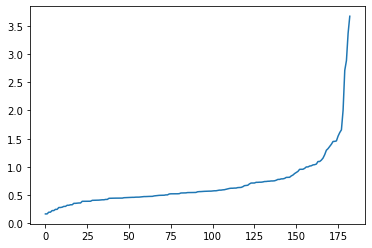

In [185]:
#Plot epsilon vs node to create elbow curve
neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [187]:
#Run DBSCAN Clustering Algorithm with chosen paraemters
epsilon = 0.6
minimumSamples = 3
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)
labels = db.labels_
labels

array([-1,  0,  0, -1,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, 11,  0, -1,  0, -1, -1,  2, -1,
       -1, -1, -1,  1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  1,  1, -1,
        2,  2, -1,  3,  3, -1,  2,  3, -1, -1,  4,  4,  2, -1, -1,  4,  5,
       -1, -1,  6,  6,  6,  2,  6,  6,  6,  7, -1,  5, -1,  5, -1, -1, 10,
        6,  6,  6,  6,  6,  6,  6,  7,  6,  7, 12,  8,  7,  8,  9, -1, -1,
        8, -1,  6,  6, -1, 10,  6,  6, 11, 12, -1,  6, -1,  9,  9,  9,  9,
        9,  9,  9, -1,  6, 12, -1, -1, 11, -1, -1,  6, -1, -1, -1, -1, -1,
       -1, -1,  9,  9,  6,  6, 10,  6, 10, -1,  6, 10, -1, 11, -1, 11, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 11,  0,  6])

In [139]:
#Add cluster labels to each postcode
df_melbdata['labels'] = labels
df_melbdata.head()

,postcode,suburb,lat,lon,enrolments,ses_score,tuition_venues,labels
0,3000,MELBOURNE,-37.814563,144.970267,275.0,1030.0,11,-1
1,3002,EAST MELBOURNE,-37.816640,144.987811,0.0,1126.0,11,0
2,3003,WEST MELBOURNE,-37.806255,144.941123,421.0,1088.0,10,0
3,3004,MELBOURNE,-37.837324,144.976335,6053.0,1116.0,11,-1
4,3005,WORLD TRADE CENTRE,-37.822262,144.954856,0.0,1104.0,10,0


In [140]:
#Plot the clusters on the folium map

map_clusters = folium.Map(location=[-37.8136, 144.9631], zoom_start=8)
kclusters = np.unique(labels).size

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, suburb, cluster in zip(df_melbdata['lat'], df_melbdata['lon'], df_melbdata['suburb'], df_melbdata['labels']):
    label = folium.Popup(str(suburb) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [167]:
#Generate summary information of each cluster

df_clusters = pd.DataFrame()

lenrol = []
lses = []
ltut = []
ltutenrol = []

for l in np.unique(labels):
    a = df_melbdata[df_melbdata['labels']==l].describe().iloc[0,3]*df_melbdata[df_melbdata['labels']==l].describe().iloc[1,3]
    b = df_melbdata[df_melbdata['labels']==l].describe().iloc[1,4]
    c = df_melbdata[df_melbdata['labels']==l].describe().iloc[0,5]*df_melbdata[df_melbdata['labels']==l].describe().iloc[1,5]
    
    lenrol.append(a)
    lses.append(b)
    ltut.append(c)
    ltutenrol.append(1000*c/a)
    
df_clusters['labels'] = np.unique(labels)
df_clusters['enrolments'] = lenrol
df_clusters['ses_score'] = lses
df_clusters['tuition_venues'] = ltut
df_clusters['tutenrol'] = ltutenrol

df_clusters

,labels,enrolments,ses_score,tuition_venues,tutenrol
0,-1,553669.0,1005.747475,172.0,0.310655
1,0,8280.0,1098.111111,93.0,11.231884
2,1,8945.0,889.000000,0.0,0.000000
3,2,13371.0,1072.500000,5.0,0.373944
4,3,11492.0,1014.333333,0.0,0.000000
5,4,634.0,1101.333333,0.0,0.000000
6,5,1638.0,1124.666667,0.0,0.000000
7,6,70352.0,1085.923077,83.0,1.179782
8,7,17307.0,1057.250000,10.0,0.577801
9,8,26885.0,1033.666667,0.0,0.000000


In [180]:
#Generate ranking information for each cluster

df_clusterranks = pd.DataFrame()
df_clusterranks['labels'] = df_clusters['labels']
df_clusterranks['enrolments'] = df_clusters['enrolments'].rank(ascending = False)
df_clusterranks['ses_score'] = df_clusters['ses_score'].rank(ascending = False)
df_clusterranks['tuition_venues'] = df_clusters['tuition_venues'].rank(ascending = True)
df_clusterranks['tutenrol'] = df_clusters['tutenrol'].rank(ascending = True)
df_clusterranks['averank'] = df_clusterranks.mean(axis=1)
df_clusterranks['overallrank'] = df_clusterranks['averank'].rank(ascending=True)
df_clusterranks

,labels,enrolments,ses_score,tuition_venues,tutenrol,averank,overallrank
0,-1,1.0,13.0,14.0,9.0,7.2,7.5
1,0,12.0,3.0,13.0,14.0,8.4,11.0
2,1,11.0,14.0,3.0,3.0,6.4,5.0
3,2,8.0,6.0,8.0,11.0,7.0,6.0
4,3,9.0,12.0,3.0,3.0,6.0,4.0
5,4,14.0,2.0,3.0,3.0,5.2,2.0
6,5,13.0,1.0,3.0,3.0,5.0,1.0
7,6,2.0,4.0,12.0,13.0,7.4,9.0
8,7,6.0,8.0,10.0,12.0,8.6,12.5
9,8,4.0,9.0,3.0,3.0,5.4,3.0


In [189]:
#Inspect data for cluster deemed most suitable for tutoring centre location
df_melbdata[df_melbdata['labels']==8]

,postcode,suburb,lat,lon,enrolments,ses_score,tuition_venues,labels
113,3134,"RINGWOOD, RINGWOOD NORTH, WARRANDYTE SOUTH, WA...",-37.783610,145.236309,9055.0,1050.0,0,8
115,3136,"CROYDON, CROYDON HILLS, CROYDON NORTH, CROYDON...",-37.788957,145.280107,8459.0,1029.0,0,8
119,3140,LILYDALE,-37.755519,145.347707,9371.0,1022.0,0,8
